In [5]:
# Linux
!source .venv/bin/activate

In [6]:
# Windows
# Dans powershell en tant qu'administrateur: set-uxecutionPolicy unrestricted
!.\.venv\Scripts\activate

/bin/bash: ligne 1: ..venvScriptsactivate : commande introuvable


In [7]:
import pandas as pd
import os
from os import chdir as cd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [8]:
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


Version:  2.18.0
GPU is available


In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
!nvidia-smi

Sat Feb  8 17:29:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:29:00.0  On |                  N/A |
|  0%   32C    P5              22W / 170W |    722MiB / 12288MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

import torch

print("CUDA is available" if torch.cuda.is_available() else "CUDA is not available")

In [11]:
cd ("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/")

### Data loading

In [12]:
df_train_data = pd.read_csv("train_data_labels.csv")

In [13]:
df_train_data.head(10)

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1
5,AE00370_023945_00_4_3_2001.jpg,0
6,AE00382_062529_00_3_1_2001.jpg,1
7,AE00354_062933_00_3_4_2001.jpg,1
8,AE00402_143834_00_1_2_2001.jpg,0
9,AE00191_070306_00_3_4_2001.jpg,0


In [14]:
df_train_data.describe()

,labels
count,10609.000000
mean,0.620417
std,0.485306
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [15]:
df_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10609 entries, 0 to 10608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  10609 non-null  object
 1   labels  10609 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 165.9+ KB


### Labels distribution

In [16]:
df_train_data["labels"].value_counts(normalize=True)

labels
1    0.620417
0    0.379583
Name: proportion, dtype: float64

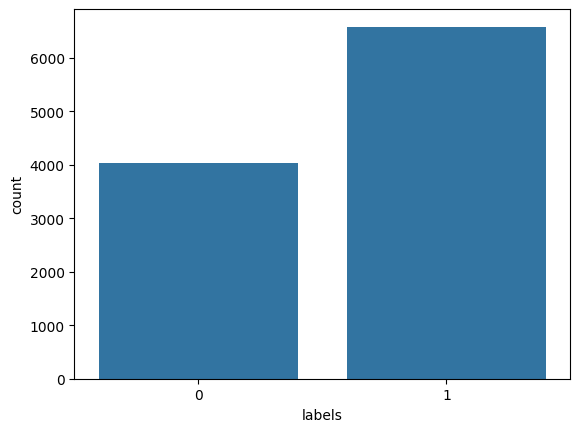

In [17]:
sns.countplot(df_train_data, x=df_train_data["labels"]);

#### We have almost twice defective parts non confirmed by the operator.

### Examples of images

0: defect confirmed by operator  
1: defect not confirmed by operator

In [18]:
list_non_confirmed = df_train_data[df_train_data["labels"]==1]["images"].reset_index()

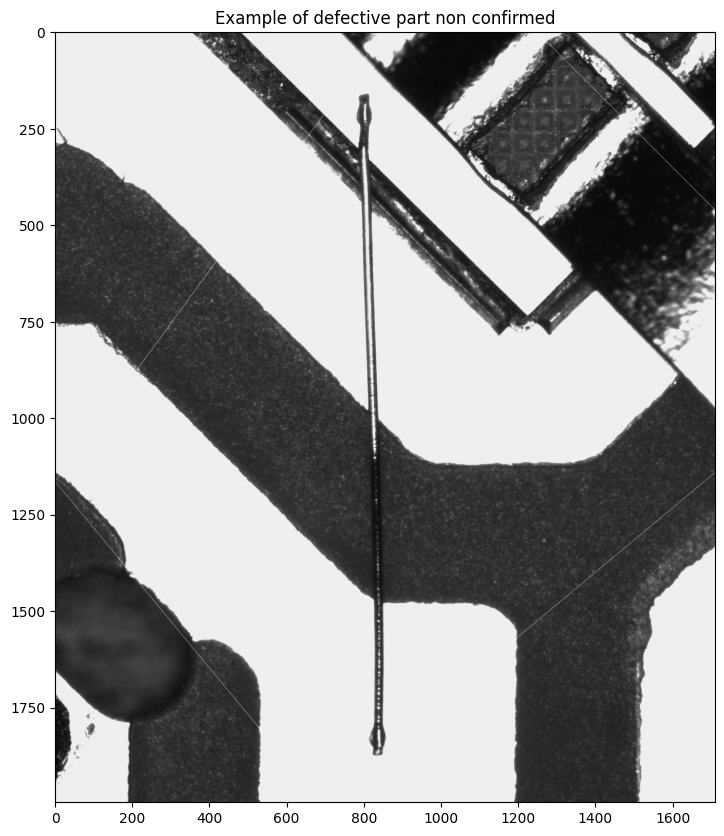

In [19]:
file = random.choice(list_non_confirmed["images"])
file_path ="./Train_Dataset/"+file
plt.figure(figsize=(10,10))
plt.title ("Example of defective part non confirmed")
img1 = cv2.imread(file_path)
plt.imshow(img1);

In [20]:
list_confirmed = df_train_data[df_train_data["labels"]==0]["images"].reset_index()

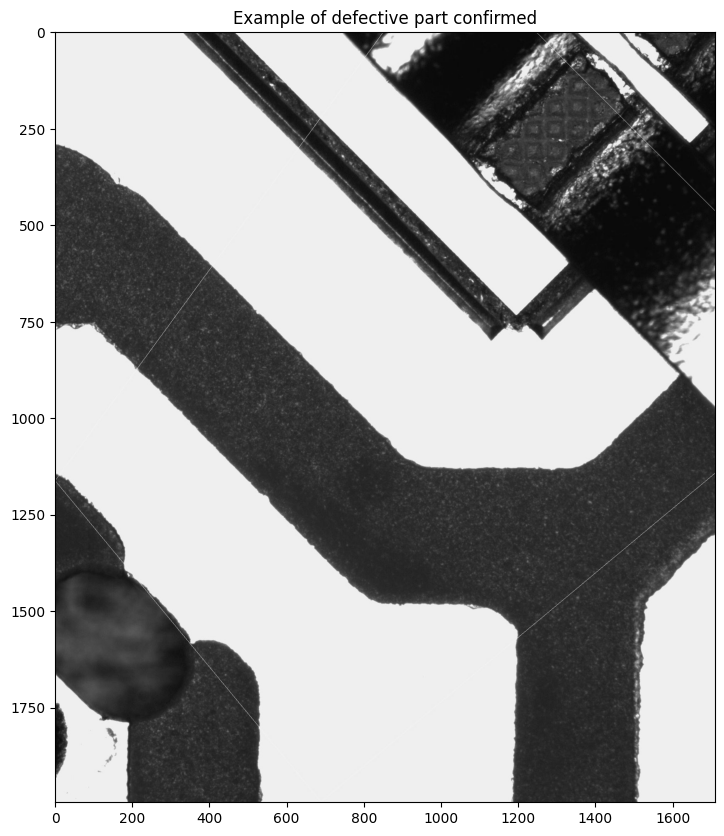

In [21]:
file2 = random.choice(list_confirmed["images"])
file_path2 ="./Train_Dataset/"+file2
plt.figure(figsize=(10,10))
plt.title ("Example of defective part confirmed")
img2 = cv2.imread(file_path2)
plt.imshow(img2);

# Training

### Split of the dataset between training and test

In [22]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df_train_data["images"], df_train_data["labels"], test_size=0.2, random_state=123)

### Loading of the images from Test Dataset and resizing

In [24]:
cd ("./Train_Dataset")

In [25]:
X_test = []
for filepath in X_test_path:
    # Read the file
    im = tf.io.read_file(filepath)
    # Decode the file
    im = tf.image.decode_jpeg(im, channels=3)
    # Resizing
    im = tf.image.resize(im, size=(256,256))
    X_test.append([im])
    
X_test = tf.concat(X_test, axis=0)

### Creation of the dataset_train

In [26]:
def load_image(filepath, resize=(256,256)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)

In [27]:
dataset_train =  tf.data.Dataset.from_tensor_slices((X_train_path, y_train))

In [28]:
dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)

# VGG16 model

In [29]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

In [30]:
# Definition of the model
base_model = VGG16(weights='imagenet', include_top=False) 

n_class = 2 # 

# Freezing of the layers
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

### Compilation

In [31]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

### Training of the model

In [32]:
history = model.fit(dataset_train, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5


I0000 00:00:1739032349.618730   48159 service.cc:148] XLA service 0x7fe13800f1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739032349.661619   48159 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-08 17:32:31.637390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739032353.223723   48159 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-08 17:32:34.240684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1801', 24 bytes spill stores, 24 bytes spill loads

2025-02-08 17:32:34.391341: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1801', 60 bytes

  2/266 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - acc: 0.6484 - loss: 1.4233   

I0000 00:00:1739032368.715149   48159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - acc: 0.8531 - loss: 0.6607

2025-02-08 17:36:35.086925: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1668808704 exceeds 10% of free system memory.
2025-02-08 17:36:36.765144: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215_0', 88 bytes spill stores, 120 bytes spill loads

2025-02-08 17:36:37.383036: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 220 bytes spill stores, 220 bytes spill loads

2025-02-08 17:36:45.582133: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 220 bytes spill stores, 220 bytes spill loads

2025-02-08 17:36:45.624069: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled 

266/266 ━━━━━━━━━━━━━━━━━━━━ 263s 913ms/step - acc: 0.8533 - loss: 0.6595 - val_acc: 0.9694 - val_loss: 0.1104
Epoch 2/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 202s 761ms/step - acc: 0.9581 - loss: 0.1358 - val_acc: 0.9764 - val_loss: 0.1057
Epoch 3/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step - acc: 0.9663 - loss: 0.1103 - val_acc: 0.9774 - val_loss: 0.0863
Epoch 4/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - acc: 0.9670 - loss: 0.1116 - val_acc: 0.9788 - val_loss: 0.0894
Epoch 5/5
266/266 ━━━━━━━━━━━━━━━━━━━━ 71s 265ms/step - acc: 0.9750 - loss: 0.0874 - val_acc: 0.9774 - val_loss: 0.0930


### Saving

In [35]:
model.save("/media/jacquin/STOCKAGE/DATA_SCIENCE/DATA_VALEO/MODEL-GPU/modelVGG16.keras")

### Plotting of the loss and accuracy in function of the epoch

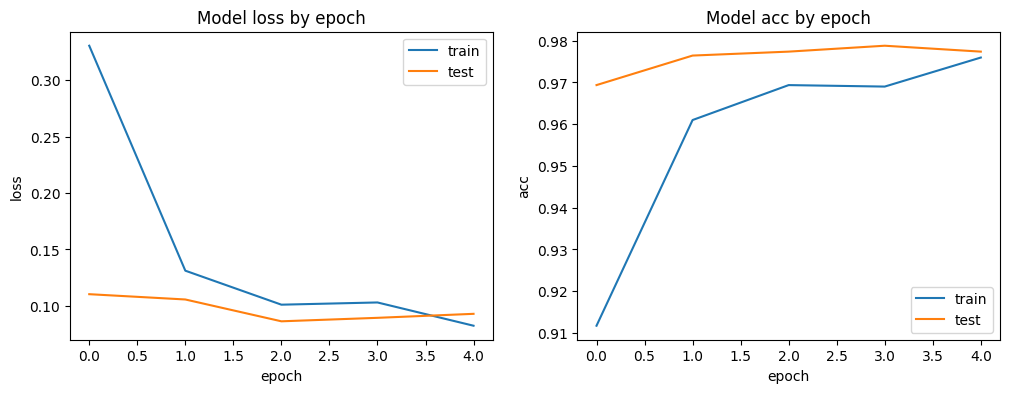

In [36]:
# Courbe de la fonction de coût et de précision en fonction de l'epoch.
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Post-processing

### Probality calculation

In [37]:
y_prob = model.predict(X_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


#### To predict the class of the image, we search the class for which the probabilty is maximum.

In [38]:
y_pred = tf.argmax(y_prob, axis=-1).numpy()

### Metrics

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [40]:
accuracy_score = accuracy_score(y_test, y_pred)
print("accuracy score:", "%.3f" % accuracy_score)

accuracy score: 0.977


In [41]:
confusion_matrix(y_test, y_pred)

array([[ 774,   46],
       [   2, 1300]])

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       820
           1       0.97      1.00      0.98      1302

    accuracy                           0.98      2122
   macro avg       0.98      0.97      0.98      2122
weighted avg       0.98      0.98      0.98      2122



### Display of the predictions

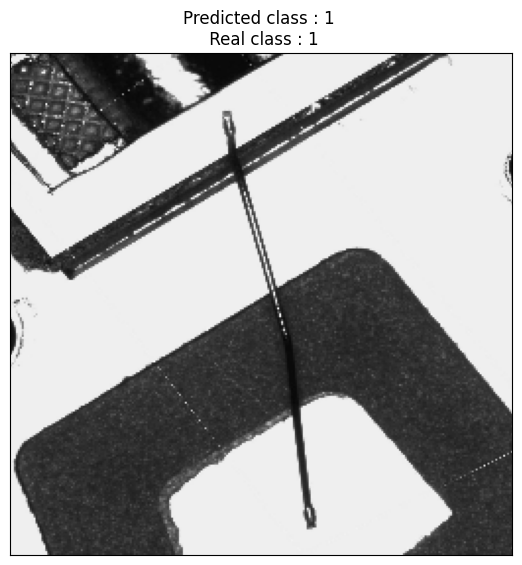

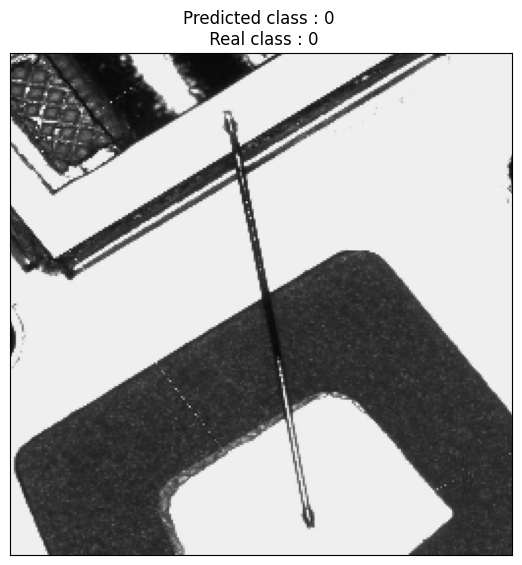

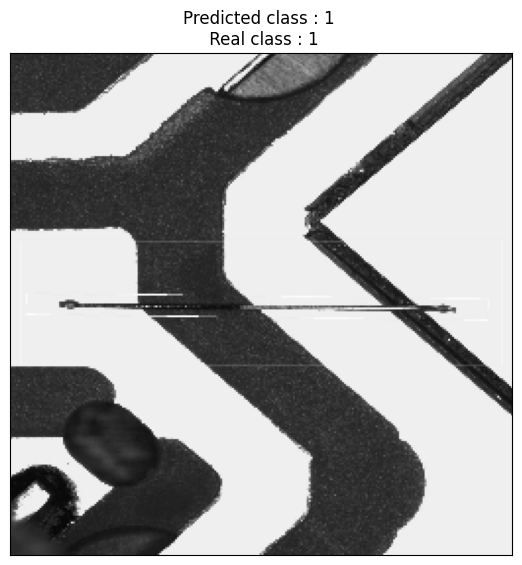

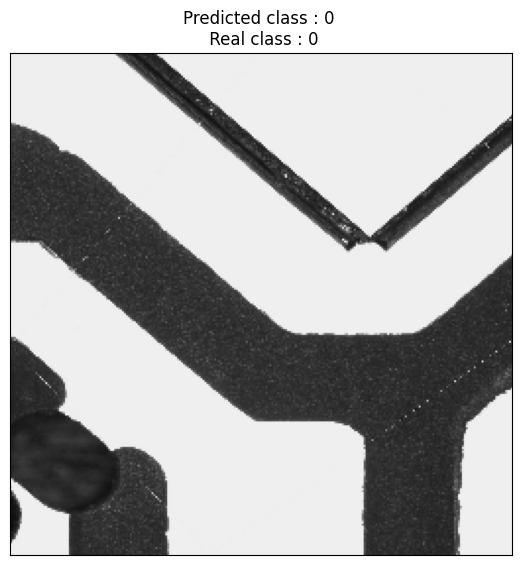

In [43]:
indices_random = tf.random.uniform([4], 0, len(X_test), dtype=tf.int32)
for i, idx in enumerate(indices_random):
    plt.figure(figsize=(30, 30))
    plt.subplot(4, 1, i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted class : {} \n Real class : {}'.format(y_pred[idx], y_test.values[idx]))